In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from Resources.Model import Model_v4
from Resources.Game import *
from Resources.TS_ModelGuided import *
from Resources.TS_ModelGuided_MCRollout import *
from Resources.TS_Unguided import *

from stockfish import Stockfish

board: 
+---+---+---+---+---+---+---+---+
| r | n | b | q | k | b | n | r | 8
+---+---+---+---+---+---+---+---+
| p | p | p | p | p | p | p | p | 7
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 6
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 5
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 4
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 3
+---+---+---+---+---+---+---+---+
| P | P | P | P | P | P | P | P | 2
+---+---+---+---+---+---+---+---+
| R | N | B | Q | K | B | N | R | 1
+---+---+---+---+---+---+---+---+
  a   b   c   d   e   f   g   h

stockfish move: ((7, 6), (5, 5), 'knight') / g1f3
board: 
+---+---+---+---+---+---+---+---+
| r | n | b | q | k | b | n | r | 8
+---+---+---+---+---+---+---+---+
| p | p | p | p | p | p | p | p | 7
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 6
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 5
+---+---+---+---+---+---+--

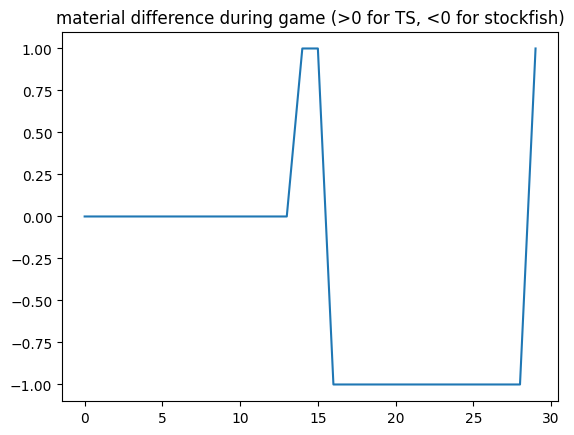

In [7]:
color = 'black'         # indicate our engine's color
tmax_TS = 10            # [s] calculations time per move for our TS
tmax_stockfish = 100    # [ms] calculation time per move for opponent
stockfish_elo = 2000    # elo of test opponent's

stockfish = Stockfish('/Users/Philip/Desktop/Projects/RL Chess/stockfish/16/bin/stockfish')
stockfish.set_elo_rating(stockfish_elo)
stockfish.set_position()

stockfish_moves = []

boards = []

if color == 'white':
    i_play = 0
elif color == 'black':
    i_play = 1

game = Game()
next_root = None
child_root = None
i = 0

mat_diffs = []

while not game.is_over():

    print('board: ')
    print(stockfish.get_board_visual())

    if i % 2 == i_play:
        # Unguided TS plays a move

        # use prints options for more information or debugging
        # use the scaling factor options to define how we navigate the search tree
        chosen_move, root = Unguided_TS(game, root=next_root, tmax=tmax_TS, prints=False, factor_wins=2, factor_mat=0.5, 
                factor_check=0.5, factor_capture=0.2, factor_attack=0.01, factor_explore=1e-3)

        boards.append(game.pieces.copy())

        # prepare child root to give next calculation a warm start (re-use current calculations)
        for child in root.children:
            if child.move == chosen_move:
                child_root = child
                break

        # get move in stockfish notation
        if color == 'white':
            stockfish_move = index_to_standard(chosen_move[0]) + index_to_standard(chosen_move[1])
        else:
            flipped_moves = game.FlipPositions([chosen_move[0], chosen_move[1]])
            stockfish_move = index_to_standard(flipped_moves[0]) + index_to_standard(flipped_moves[1])

        print('TS move with {} visits: {} / {}'.format(child_root.visits, chosen_move, stockfish_move))

        mat_diff = game.MaterialDiff()
        mat_diffs.append(mat_diff)

    else:
        # get best move given time constraint from stockfish
        stockfish_move = stockfish.get_best_move_time(tmax_stockfish)

        move_from = standard_to_index(stockfish_move[0:2])
        move_to = standard_to_index(stockfish_move[2:4])

        for poss_move in game.PossibleMoves():
            if move_from == poss_move[0] and move_to == poss_move[1]:
                chosen_move = poss_move
                break

        print('stockfish move: {} / {}'.format(chosen_move, stockfish_move))

    # update move in stockfish game instance 
    stockfish.make_moves_from_current_position([stockfish_move])

    stockfish_moves.append(stockfish_move)
    
    game.PlayMove(chosen_move)
    game.FlipBoard()

    i += 1

print('board: ')
print(stockfish.get_board_visual())

winner = game.get_winner()
print('winner: ', winner)

plt.plot(mat_diffs)
plt.title('material difference during game (>0 for TS, <0 for stockfish)')
plt.show()
